# Semantic Text Splitting
This notebook demonstrates different semantic text splitters. It will compare publicly available semantic chunking librarys and a self written one.
With these results we determine which one to use and build the text splitting & chunking step based on it.


## Setup

In [239]:
from IPython.display import display

import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()


## Loading the file
We use the paper *Managing North-South Research Collaboration Projects During the COVID-19 Pandemic. An Empirical Study* for this example. This file is already preprocessed by the NOUGAT-model by Meta [(1)](https://facebookresearch.github.io/nougat/).


In [240]:
def print_pretty(data):
    if type(data) == list:
        for item in data:
            display(item)
    else:
        split_lines = data.split("\\n")
        for split_line in split_lines:
            display(split_line)
        
file_path = 'data/sulayman_corona.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
data = lines[0]



## Preprocessing
Extract tables with their heading 


In [241]:
import re

def find_and_remove_patter(data, pattern):
    found_pattern = re.findall(pattern, data, re.DOTALL)
    print(f"Found {len(found_pattern)} patterns")
    for entry in found_pattern:
        data = re.sub(re.escape(entry), '', data)
    return data, found_pattern

# Define the regular expression pattern
pattern_table = r"\\begin{table}.*?\\end{table}"
pattern_tabulate = r"\\begin{tabular}.*?\\end{tabular}"

data, tables1 = find_and_remove_patter(data, pattern_table)
data, tables2 = find_and_remove_patter(data, pattern_tabulate)

tables = tables1 + tables2

print(f"Found {len(tables)} tables")

# Print the updated data
print_pretty(data)
print_pretty(tables1)


Found 6 patterns
Found 1 patterns
Found 7 tables
Managing North-South Research Collaboration Projects

During the COVID-19 Pandemic. An Empirical Study

Anonymous author(s)

**Abstract**

Researchers from the global North and South have collaborated for decades to conduct cutting-edge interdisciplinary research. The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change? Survey data, semi-structured interviews, and personal accounts from 102 respondents from 33 countries are used in this empirical study to investigate the impact of the pandemic on research collaboration projects. An independent non-parametric t-test revealed a significant difference in the research collaboration infrastructure and home environment between global North and global South colla

## Splitting into sentences

In [242]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
import pandas as pd
from tabulate import tabulate


sentences = sent_tokenize(data)
# Create a DataFrame with the sentences
df = pd.DataFrame({'Sentences': sentences})
print(tabulate(df, headers='keys', tablefmt='psql'))



+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     | Sentences                                                          

[nltk_data] Downloading package punkt to /Users/philipp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Group the sentences together

In [243]:
def build_sentence_dict(sentences: list) -> dict:
    sentence_dict  = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences)]
    return sentence_dict

def combine_sentences(sentences:dict, sentence_window=1):
    for i in range(len(sentences)):
        combined_sentence = ''
        for j in range(i - sentence_window, i):
            if j >= 0:
                combined_sentence += sentences[j]['sentence'] + ' '
        combined_sentence += sentences[i]['sentence']
        for j in range(i + 1, i + 1 + sentence_window):
            if j < len(sentences):
                combined_sentence += ' ' + sentences[j]['sentence']
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentence_dict = build_sentence_dict(sentences)
sentence_dict = combine_sentences(sentence_dict, sentence_window=1)
display(sentence_dict[3:6])

[{'sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration.',
  'index': 3,
  'combined_sentence': 'The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change?'},
 {'sentence': 'How are researchers and project managers adapting to this change?',
  'index': 4,
  'combined_sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change? Survey data, semi-structured interviews, and personal accounts from 102 respondents from 33 countries are used in this empirical study to investigate the impact of the pandemic on research collaboration projects.'},
 {'sentence': 'Survey data, semi-structured interviews, and pe

## Tokenize using TikToken

In [244]:
from tiktoken import Encoding, get_encoding

def tokenize_sentences(sentence_dict: dict, encoding_name: str) -> dict:
    encoding: Encoding = get_encoding(encoding_name)
    for sentence in sentence_dict:
        sentence['tokens'] = encoding.encode(sentence['combined_sentence'])
    return sentence_dict

sentence_dict = tokenize_sentences(sentence_dict, 'cl100k_base')

display(sentence_dict[3:4])


[{'sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration.',
  'index': 3,
  'combined_sentence': 'The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change?',
  'tokens': [791,
   7526,
   814,
   1511,
   311,
   10299,
   872,
   3495,
   7224,
   14958,
   21907,
   35957,
   3156,
   279,
   20562,
   12,
   777,
   28522,
   31188,
   4216,
   304,
   220,
   2366,
   15,
   13,
   8876,
   1243,
   11,
   264,
   2763,
   706,
   5614,
   11,
   2737,
   279,
   7138,
   323,
   30295,
   315,
   3495,
   20632,
   13,
   2650,
   527,
   12074,
   323,
   2447,
   20258,
   70817,
   311,
   420,
   2349,
   30]}]

## Create Embeddings for the sentences

In [245]:
from langchain_openai import OpenAIEmbeddings

def embed_sentences(sentence_dict: dict, model_name: str = "text-embedding-ada-002") -> dict:
    oaiembeddings = OpenAIEmbeddings(model=model_name)
    embeddings = oaiembeddings.embed_documents([x['combined_sentence'] for x in sentence_dict])
    for i, sentence in enumerate(sentence_dict):
        sentence['combined_sentence_embedding'] = embeddings[i]
    return sentence_dict

sentence_dict = embed_sentences(sentence_dict)

display(sentence_dict[3:4])

[{'sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration.',
  'index': 3,
  'combined_sentence': 'The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change?',
  'tokens': [791,
   7526,
   814,
   1511,
   311,
   10299,
   872,
   3495,
   7224,
   14958,
   21907,
   35957,
   3156,
   279,
   20562,
   12,
   777,
   28522,
   31188,
   4216,
   304,
   220,
   2366,
   15,
   13,
   8876,
   1243,
   11,
   264,
   2763,
   706,
   5614,
   11,
   2737,
   279,
   7138,
   323,
   30295,
   315,
   3495,
   20632,
   13,
   2650,
   527,
   12074,
   323,
   2447,
   20258,
   70817,
   311,
   420,
   2349,
   30],
  'combined_sentence_embedding': [0.005322070729592709,
   -0.021677227469364384,
   -0.0

## Calculate distances


In [246]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_distance(sentence_dict: dict) -> dict:
    distances = []
    for i in range(len(sentence_dict) - 1):
        embedding_current = sentence_dict[i]['combined_sentence_embedding']
        embedding_next = sentence_dict[i + 1]['combined_sentence_embedding']
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        distance = 1 - similarity
        distances.append(distance)
        sentence_dict[i]['distance_to_next'] = distance
    return distances, sentence_dict

distances, sentence_dict = calculate_distance(sentence_dict)
display(distances[:5] )
display(len(distances))

[0.0067685433570003894,
 0.029197444296526376,
 0.09669181383763625,
 0.05462047009736393,
 0.04237522892671475]

428

## Show the results

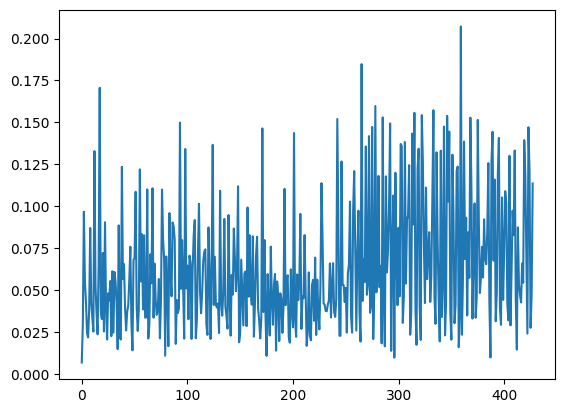

In [247]:
import matplotlib.pyplot as plt

plt.plot(distances);

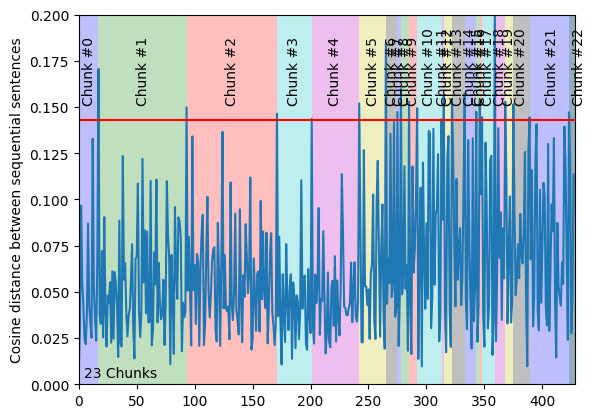

In [251]:
import numpy as np
def plot_distances(distances: list):
    plt.plot(distances);

    y_upper_bound = .2
    plt.ylim(0, y_upper_bound)
    plt.xlim(0, len(distances))

    # We need to get the distance threshold that we'll consider an outlier
    # We'll use numpy .percentile() for this
    breakpoint_percentile_threshold = 95
    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
    plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

    # Then we'll see how many distances are actually above this one
    num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
    plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

    # Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

    # Start of the shading and text
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, breakpoint_index in enumerate(indices_above_thresh):
        start_index = 0 if i == 0 else indices_above_thresh[i - 1]
        end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

        plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
        plt.text(x=np.average([start_index, end_index]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i}", horizontalalignment='center',
                rotation='vertical')

    # # Additional step to shade from the last breakpoint to the end of the dataset
    if indices_above_thresh:
        last_breakpoint = indices_above_thresh[-1]
        if last_breakpoint < len(distances):
            plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
            plt.text(x=np.average([last_breakpoint, len(distances)]),
                    y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                    s=f"Chunk #{i+1}",
                    rotation='vertical')

    plt.ylabel("Cosine distance between sequential sentences")
    plt.show()

plot_distances(distances)

## Create Chunks


In [265]:
def split_chunks(sentence_dict: dict, distances: list, threshold: int = 95) -> dict:
    breakpoint_distance_threshold = np.percentile(distances, threshold) # If you want more chunks, lower the percentile cutoff
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list
    start_index = 0
    chunks = []
    for index in indices_above_thresh:
        end_index = index
        group = sentence_dict[start_index:end_index]
        combined_text = ' '.join([d['sentence'] for d in group])
        chunks.append(combined_text)
        start_index = index + 1
    if start_index < len(sentences):
        combined_text = ' '.join([d['sentence'] for d in sentence_dict[start_index:]])
        chunks.append(combined_text)
    return chunks
        
chunks = split_chunks(sentence_dict, distances, 95)


for i, chunk in enumerate(chunks):
    display (f"Chunk #{i}")
    print_pretty(chunk)
    display ("\n")

'Chunk #0'

Managing North-South Research Collaboration Projects

During the COVID-19 Pandemic. An Empirical Study

Anonymous author(s)

**Abstract**

Researchers from the global North and South have collaborated for decades to conduct cutting-edge interdisciplinary research. The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change? Survey data, semi-structured interviews, and personal accounts from 102 respondents from 33 countries are used in this empirical study to investigate the impact of the pandemic on research collaboration projects. An independent non-parametric t-test revealed a significant difference in the research collaboration infrastructure and home environment between global North and global South collaborators. The findings have practical implication

'\n'

'Chunk #1'

Africa). The research projects are parts of the Clusters of Excellence research projects funded by the German Excellence Strategy. Cluster members have a long history of interdisciplinary North-South research collaboration. The aim of the Cluster, among other things, is to develop a digital research environment for reconfiguring African Studies (Seesemann,2020). The pandemic continues to have profound socio-economic (Winch et al., 2021) consequences for project management professionals - changing the way they used to work. Like many other collaborative projects, we are also heavily impacted by the COVID-19 pandemic. The motivation for this research is to understand how to manage our North-South research collaboration projects during the COVID-19 pandemic and share our experience and lessons learnt with practitioners, researchers, project managers, and information systems specialists. Project management uses specific tools and techniques to deliver a valuable product to the people or co

'\n'

'Chunk #2'

(2020) and Muqattash et al. (2020) used a similar survey instrument to collect data during the pandemic. The methodology is divided into three stages.

1. **Preparation**: During the preparatory stage, we carried out a series of brainstorming sessions to discuss the types of questions to ask, under what sections the questions should appear, and the logic needed to redirect respo

Figure 1: North-South research collaboration projects data collection methodology.

of sketches, we designed the survey questionnaire using LimeSurvey (LimeSurvey Development Team, 2020). The questionnaire was then tested and piloted with a small group of researchers, principal investigators and research projects managers. After addressing the feedback from the pilot group, we modified and deployed the survey online. Some of the feedback included removing the mandatory option for some of the questions. The finalised questionnaire contained 25 questions spread across four sections presented in Table 1.
2. **Dep

'\n'

'Chunk #3'

10% are working from home but sometimes go to their offices to work on their research projects. The average number of countries visited by the respondents was 1.11 (Std. Dev. = 0.89), and the maximum number of countries visited by one individual from the global North was 4.

When asked to rank the factors affecting their ability to work from home, participants from both the global North and South reported that the most significant effect (of the lockdown) is the lack of direct face-to-face contact with colleagues (Figure 7 and Table 4). Researchers also have difficulty in contacting research partners and scheduling meetings when working from home.

Furthermore, when asked to rank what distracts them most when working from home, most people reported that children are the most distracting. Distractions from phone calls and messaging and other forms of distractions not captured in the survey also rank high amongst the respondents. Table 4 shows that there is a significant difference betwe

'\n'

'Chunk #4'

In particular, the dataset used in this study is a small dataset and by no means representative of the entire global North and South research collaboration population or projects. The dataset only consists of 64 respondents from 14 Northern countries and 38 respondents from 19 Southern countries. We also mentioned that the country of residence data is skewed because respondents from Germany and Nigeria alone account for more than a third of all the respondents from the 33 countries (ref. Table 2).

While the North-South research collaboration data collection methodology presented in Figure 1 gave us all the instruments needed to craft a good survey, the questionnaire was not able to capture some elements where the participants expressed strong opinions. For example, there is no way of knowing from the demographic data the profession of 4% of the people surveyed, the other technologies and platforms researchers are using to collaborate with their colleagues (discussed in Section 4.1), o

'\n'

'Chunk #5'

The grouping helped us trim the complex nature of research collaboration to just these two manageable dimensions. The methodology shows how we planned, designed, piloted and deployed the survey data collection instrument or questionnaire. We used the analytical framework to explain how we applied an independent nonparametric _t_-test and other statistical measures to analyse the survey data we obtained from 102 researchers coming from 33 different countries.

The results and discussion presented helped us understand the complex nature of research collaboration projects and how the pandemic has changed the way project managers used to manager research projects prior to the pandemic. In managing a research collaboration project, the project is usually involved in several essential project management activities. The activities may include project planning and tracking, managing project resources (human and research material), estimating and calculating costs, schedule management (conferen

'\n'

'Chunk #6'

Collaborations: The fourth age of research. _Nature_, _497_, 557-60.
* Adepoju (2020) Adepoju, P. (2020). COVID-19 puts health research to the test in africa. _Nature Medicine_, _26_, 1312-1314.
* Archibald et al. (2019) Archibald, M. M., Ambagtsheer, R. C., Casey, M. G., & Lawless, M. (2019). Using zoom videoconferencing for qualitative data collection: Perceptions and experiences of researchers and participants. _International Journal of Qualitative Methods_, _18_, 1609-4069. [https://doi.org/10.1177/1609406919874596](https://doi.org/10.1177/1609406919874596)Bian, S. X., & Lin, E. (2020). Competing with a pandemic: Trends in research design in a time of COVID-19.


'\n'

'Chunk #7'

[https://doi.org/10.1371/journal.pone.0238831](https://doi.org/10.1371/journal.pone.0238831)
* Bradley (2008) Bradley, M. (2008). On the agenda: North-south research partnerships and agenda-setting processes.


'\n'

'Chunk #8'

[https://doi.org/10.1080/09614520802386314](https://doi.org/10.1080/09614520802386314)
* Burki (2021) Burki, T. K. (2021). Lifting of covid-19 restrictions in the uk and the delta variant. _The Lancet Respiratory Medicine_, _9_(8), e85. [https://doi.org/https://doi.org/10.1016/S2213-2600](https://doi.org/https://doi.org/10.1016/S2213-2600)(21)00328-3
* Camelia (2022) Camelia, D. (2022). What the covid-19 crisis can teach us about project management? [https://www.sciforma.com/blog/what-covid-19-crisis-can-teach-us-about-project-management](https://www.sciforma.com/blog/what-covid-19-crisis-can-teach-us-about-project-management)
* De' et al.


'\n'

'Chunk #9'

(2020). Impact of digital surge during Covid-19 pandemic: A viewpoint on research and practice. _International Journal of Information Management_, _55_, 102-171. [https://doi.org/10.1016/j.ijinfomgt.2020.102171](https://doi.org/10.1016/j.ijinfomgt.2020.102171)
* from great challenge to unique opportunity: Perspective. _Annals of Medicine and Surgery_, _59_, 68-71.
* Erno-Kjolhede (1999) Erno-Kjolhede, E. (1999). _Project management theory and the management of research projects_ (WorkingPaper No.


'\n'

'Chunk #10'

Department of Management, Politics and Philosophy, CBS. Denmark, Department of Management, Politics; Philosophy, CBS.
* Freeth & Vilsmaier (2019) Freeth, R., & Vilsmaier, U. (2019). Researching collaborative interdisciplinary teams: Practices and principles for navigating researcher positionality. _Science and Technology Studies_, _33_(3), 57-72.
* Gaillard (1994) Gaillard, J. (1994). North-south research partnership: Is collaboration possible between unequal partners? _Knowledge and Policy_, \\(7\\), 31-63.
* Grasenick & Guerrero (2020) Grasenick, K., & Guerrero, M. (2020). Responsible research and innovation & digital inclusiveness during COVID-19 crisis in the human brain project (HBP). _Journal of Responsible Technology_, \\(1\\), 100-001. [https://doi.org/10.1016/j.jrt.2020.06.001](https://doi.org/10.1016/j.jrt.2020.06.001)
* Heymann et al. (2016) Heymann, D. L., Liu, J., & Lillywhite, L. (2016). Partnerships, not parachutists, for zika research. _New England Journal of Medicine_,

'\n'

'Chunk #11'

[https://doi.org/10.31244/zep.2019.02.03](https://doi.org/10.31244/zep.2019.02.03)
* Kuhfeld et al.


'\n'

'Chunk #12'

(2020). Projecting the potential impact of COVID-19 school closures on academic achievement. _Educational Researcher_, _49_(8), 549-565. [https://doi.org/10.3102/0013189X20965918](https://doi.org/10.3102/0013189X20965918)Lee, J., & Haupt, J. (2020). Scientific globalism during a global crisis: Research collaboration and open access publications on COVID-19.


'\n'

'Chunk #13'

[https://doi.org/10.1007/s10734-020-00589-0](https://doi.org/10.1007/s10734-020-00589-0)
* Lee & Bozeman (2005) Lee, S., & Bozeman, B. (2005). The impact of research collaboration on scientific productivity. _Social Studies of Science_, _35_(5), 673-702. [https://doi.org/10.1177/0306312705052359](https://doi.org/10.1177/0306312705052359)
* the Free and Open Source survey software tool_. LimeSurvey Development Team. limesurvey.org
* Maina-Ahlberg et al. (1997) Maina-Ahlberg, B., Nordberg, E., & Tomson, G. (1997). North-south health research collaboration: Challenges in institutional interaction. _Social Science & Medicine_, _44_(8), 1229-1238.


'\n'

'Chunk #14'

(2020). Industry-academia research collaboration in software engineering: The certus model. _Information and Software Technology_, 106473. [https://doi.org/10.1016/j.infsof.2020.106473](https://doi.org/10.1016/j.infsof.2020.106473)
* Mawazo (2020) Mawazo. (2020). Mawazo institute COVID-19 survey report. [https://doi.org/10.31730/osf.io/m3tc2](https://doi.org/10.31730/osf.io/m3tc2)
* Minasny et al. (2020) Minasny, B., Fiantis, D., Mulyanto, B., Sulaeman, Y., & Widyatmanti, W. (2020). Global soil science research collaboration in the 21st century: Time to end helicopter research.


'\n'

'Chunk #15'

[https://doi.org/10.1016/j.geoderma.2020.114299](https://doi.org/10.1016/j.geoderma.2020.114299)
* Mummery (2020) Mummery, C. (2020). Scientific collaboration and communication in the time of COVID-19: A chat with christine mummery.


'\n'

'Chunk #16'

[https://doi.org/10.1016/j.stem.2020.11.007](https://doi.org/10.1016/j.stem.2020.11.007)
* Muqattash et al.


'\n'

'Chunk #17'

(2020). Survey data for COVID-19 vaccine preference analysis in the united arab emirates. _Data in Brief_, _33_, 106-446. [https://doi.org/10.1016/j.dib.2020.106446](https://doi.org/10.1016/j.dib.2020.106446)
* Nicola et al. (2020) Nicola, M., Alsafi, Z., Sohrabi, C., Kerwan, A., Al-Jabir, A., Iosifidis, C., Agha, M., & Agha, R. (2020). The socio-economic implications of the coronavirus pandemic (COVID-19): A review. _International Journal of Surgery_, _78_, 185-193. [https://doi.org/10.1016/j.ijsu.2020.04.018](https://doi.org/10.1016/j.ijsu.2020.04.018)
* Nieto et al. (2020) Nieto, R., Pardo, R., Sora, B., Feliu-Soler, A., & Luciano, J. V. (2020). Impact of COVID-19 lockdown measures on spanish people with chronic pain: An online study survey.


'\n'

'Chunk #18'

[https://doi.org/10.3390/jcm9113558](https://doi.org/10.3390/jcm9113558)
* Porter & Birdi (2018) Porter, J. J., & Birdi, K. (2018). 22 reasons why collaborations fail: Lessons from water innovation research. _Environmental Science & Policy_, _89_, 100-108. [https://doi.org/10.1016/j.envsci.2018.07.004](https://doi.org/10.1016/j.envsci.2018.07.004)
* R Core Team (2020) R Core Team. (2020). _R: A programming environment for data analysis and graphics_. R Foundation for Statistical Computing. Vienna, Austria.


'\n'

'Chunk #19'

(2020). Is remote the new normal? reflections on COVID-19, technology, and humankind. _Interactions_, _27_(4), 42-46. [https://doi.org/10.1145/3403586](https://doi.org/10.1145/3403586)Russo, D., Hanel, P. P. H., Altnickel, S., & van Berkel, N. (2021). The daily life of software engineers during the covid-19 pandemic.
* Seesemann (2020) Seesemann, R. (2020).


'\n'

'Chunk #20'

rep.). Institute of African Studies, Bayreuth, Germany. University of Bayreuth, Germany : Institute of African Studies. [https://doi.org/10.15495/EPub_UBT_00005120](https://doi.org/10.15495/EPub_UBT_00005120)
* Sein (2020) Sein, M. K. (2020). The serendipitous impact of COVID-19 pandemic: A rare opportunity for research and practice. _International Journal of Information Management_, _55_, 102164.
* Shenhar and Dvir (2007) Shenhar, A. J., & Dvir, D. (2007). Project management research--the challenge and opportunity. _Project Management Journal_, _38_(2), 93-99. [https://doi.org/10.1177/875697280703800210](https://doi.org/10.1177/875697280703800210)
* Sowe et al. (2021) Sowe, S. K., Schonfeld, M., Samimi, C., Steiner, P., & Huisl, J. (2021). Impact of the covid-19 pandemic for north-south research collaboration : An experience report. _Companion volume to the proceedings of the 17th international symposium on open collaboration_ (pp.


'\n'

'Chunk #21'

ACM. [https://eref.uni-bayreuth.de/67248/](https://eref.uni-bayreuth.de/67248/)
* Sowe et al. (2008) Sowe, S. K., Stamelos, I., & Angelis, L. (2008). Understanding Knowledge Sharing Activities in Free/Open Source Software Projects: An Empirical Study. _Journal of Systems and Software_, _81_(3), 431-446. [https://doi.org/10.1016/j.jss.2007.03.086](https://doi.org/10.1016/j.jss.2007.03.086)
* Spier and Evans (2021) Spier, A. B., & Evans, C. E. (2021). Surviving and thriving in thrombosis research during a global pandemic: Experiences of a vascular scientist diagnosed with COVID-19. _Thrombosis Update_, \\(2\\), 100028. [https://doi.org/10.1016/j.tru.2020.100028](https://doi.org/10.1016/j.tru.2020.100028)
* Tangwa and Munung (2020) Tangwa, G. B., & Munung, N. S. (2020). COVID-19: Africa's relation with epidemics and some imperative ethics considerations of the moment. _Research Ethics_, _16_(3-4), 1-11. [https://doi.org/10.1177/1747016120937391](https://doi.org/10.1177/1747016120937391)
*

'\n'

'Chunk #22'

[https://doi.org/10.1007/s11192-021-03873-7](https://doi.org/10.1007/s11192-021-03873-7)
* Zaer et al. (2020) Zaer, H., Fan, W., Orlowski, D., Glud, A. N., Andersen, A. S. M., Schneider, M. B., Adler, J. R., Stroh, A., & Sorensen, J. C. H. (2020). A perspective of international collaboration through web-based telecommunication-inspired by covid-19 crisis. _Frontiers in Human Neuroscience_, _14_, 502. [https://doi.org/10.3389/fnhum.2020.577465](https://doi.org/10.3389/fnhum.2020.577465)


'\n'